Import packages

In [2]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

Load the Nashville zipcode data

In [3]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37115,1,MADISON,178783.02488886821,596553400.57885742,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,3,NASHVILLE,75820.997821400058,188884682.28344727,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,9,NASHVILLE,93180.292250425613,200664795.51708984,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,11,BRENTWOOD,159760.6942933173,174978422.04101562,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,18,FRANKLIN,28995.828320601937,46969608.005737305,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


Read art data

In [7]:
art = pd.read_csv('../data/art_in_nashville.csv')
print(art.shape)
art.head(3)

(164, 10)


,Title,Artist Last Name,Artist First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location
0,Les Paul Guitar Mural,Hughes,Milree,"100 Broadway, Nashville TN",Painting,Mural,NaN,36.16240,-86.77491,"(36.1624, -86.77491)"
1,Sam Davis,LeQuire,Alan,"4001 Harding Road, Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)"
2,The Flutist,Varo,Marton,"1 Symphony Place, Nashville TN",Marble,Sculpture,"Statue commemorating Kenneth D Schermerhorn, M...",36.15961,-86.77594,"(36.15961, -86.77594)"


In [8]:
art.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              164 non-null    object 
 1   Artist Last Name   164 non-null    object 
 2   Artist First Name  159 non-null    object 
 3   Location           164 non-null    object 
 4   Medium             162 non-null    object 
 5   Type               164 non-null    object 
 6   Description        107 non-null    object 
 7   Latitude           162 non-null    float64
 8   Longitude          162 non-null    float64
 9   Mapped Location    162 non-null    object 
dtypes: float64(2), object(8)
memory usage: 12.9+ KB


Create a GeoDataFrame of art.

In [14]:
art['geometry'] = art.apply(lambda x: Point((x.Longitude, 
                                            x.Latitude)), 
                                        axis=1)
art.head(3)

,Title,Artist Last Name,Artist First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location,geometry
0,Les Paul Guitar Mural,Hughes,Milree,"100 Broadway, Nashville TN",Painting,Mural,NaN,36.16240,-86.77491,"(36.1624, -86.77491)",POINT (-86.77491000000001 36.1624)
1,Sam Davis,LeQuire,Alan,"4001 Harding Road, Nashville TN",Bronze,Sculpture,NaN,36.12856,-86.83660,"(36.12856, -86.8366)",POINT (-86.8366 36.12856)
2,The Flutist,Varo,Marton,"1 Symphony Place, Nashville TN",Marble,Sculpture,"Statue commemorating Kenneth D Schermerhorn, M...",36.15961,-86.77594,"(36.15961, -86.77594)",POINT (-86.77594000000001 36.15961)


Get the CRS for art to match the CRS in zipcodes.

In [17]:
zipcodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
art_geo = gpd.GeoDataFrame(art, 
                           crs = zipcodes.crs, 
                           geometry = art['geometry'])

In [20]:
type(art_geo)

geopandas.geodataframe.GeoDataFrame

Clean zipcodes and do a spacial join with art.

In [21]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

In [22]:
art_by_zip = gpd.sjoin(art_geo, zipcodes, op = 'within')

In [23]:
art_by_zip.head()

,Title,Artist Last Name,Artist First Name,Location,Medium,Type,Description,Latitude,Longitude,Mapped Location,geometry,index_right,zip,po_name
0,Les Paul Guitar Mural,Hughes,Milree,"100 Broadway, Nashville TN",Painting,Mural,NaN,36.16240,-86.77491,"(36.1624, -86.77491)",POINT (-86.77491 36.16240),36,37201,NASHVILLE
2,The Flutist,Varo,Marton,"1 Symphony Place, Nashville TN",Marble,Sculpture,"Statue commemorating Kenneth D Schermerhorn, M...",36.15961,-86.77594,"(36.15961, -86.77594)",POINT (-86.77594 36.15961),36,37201,NASHVILLE
11,Orpheus and Eurydice,Kaskey,Ray,"1 Symphony Place, Nashville TN",Limestone,Sculpture,Relief sculpture above main entrance of Scherm...,36.16017,-86.77575,"(36.16017, -86.77575)",POINT (-86.77575 36.16017),36,37201,NASHVILLE
21,The Birth of Apollo,Eskridge,Casey,"1 Symphony Place, Nashville TN",Bronze sculpture as centerpiece of fountain,Sculpture,"Two figures topping a fountain, one with a lyr...",36.15993,-86.77611,"(36.15993, -86.77611)",POINT (-86.77611 36.15993),36,37201,NASHVILLE
24,The Recording Angel,Flack,Audrey,"1 Symphony Place, Nashville TN",Bronze,Sculpture,Bronze angel holding a fountain pen and tablet,36.15920,-86.77571,"(36.1592, -86.77571)",POINT (-86.77571 36.15920),36,37201,NASHVILLE


Count art in each zipcode.

In [24]:
art_by_zip['zip'].value_counts()

37219    33
37203    25
37201    21
37210    11
37212    10
37205    10
37206     9
37208     7
37214     6
37221     6
37209     4
37204     4
37115     3
37240     2
37213     2
37215     2
37207     2
37211     2
37216     2
37076     1
Name: zip, dtype: int64

Take a look at art in 37219

In [26]:
art_downtown = art_by_zip.loc[art_by_zip['zip'] == '37219']
art_downtown.shape

(33, 14)

In [27]:
polygon37219 = zipcodes.loc[zipcodes['zip'] == '37219']
polygon37219.shape

(1, 3)

Plot them together

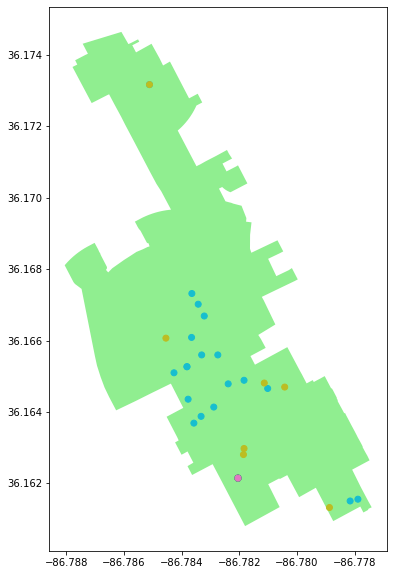

In [29]:
ax = polygon37219.plot(figsize = (8, 10), color = 'lightgreen')
art_downtown.plot( ax = ax, column = 'Type');
plt.show();

Add map

In [30]:
polygon37219.geometry.centroid

C:\Users\16159\AppData\Local\Temp/ipykernel_42932/226734311.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon37219.geometry.centroid


24    POINT (-86.78317 36.16682)
dtype: geometry

Find the center

In [32]:
center = polygon37219.geometry.centroid[24]
print(center)

POINT (-86.78317337070099 36.16681838008157)


C:\Users\16159\AppData\Local\Temp/ipykernel_42932/1179354559.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = polygon37219.geometry.centroid[24]


Construct array for folium location

In [33]:
# reverse the order when constructing the array for folium location
area_center = [center.y, center.x]

# check the order of area_center, the location for our folium map
print(area_center)

[36.16681838008157, -86.783173370701]


Create folium map of downtown

In [43]:
map_37219 = folium.Map(location = area_center, zoom_start = 15)
map_37219

Add the polygon and the art markers.

In [45]:
i = 0
for row_index, row_values in art_downtown.iterrows():
    if i <3: 
        print('index is', row_index)
        print('values are:')
        print(' ')
        print(row_values)
        print('------------------------- ')
        i+=1

index is 4
values are:
 
Title                                                     Anticipation
Artist Last Name                                                 Faxon
Artist First Name                                              Russell
Location                            505 Deaderick Street, Nashville TN
Medium                                                Cold cast bronze
Type                                                         Sculpture
Description          A statue of a woman with legs crossed sitting ...
Latitude                                                      36.16489
Longitude                                                    -86.78184
Mapped Location                                  (36.16489, -86.78184)
geometry                                    POINT (-86.78184 36.16489)
index_right                                                         24
zip                                                              37219
po_name                                             

Create map_37207 again with additional features:
add the zipcode area outline (polygon_37207)
iterate through the stops_in_37207 to create location from each lat and lng
create a popup from the stop column
create a custom icon if you want with font-awesome
build a marker from each location and popup and your custom icon
add the marker to map_37207
display map_37207

In [61]:
#draw our zip code area: 37219
map_37219 = folium.Map(location =  area_center, zoom_start = 15)

folium.GeoJson(polygon37219).add_to(map_37219)

#iterate through art_downtown to create locations and markers 
#for each art piece
#remember for Folium locations, lat is listed first!!

for row_index, row_values in art_downtown.iterrows():
    loc = [row_values['Latitude'], row_values['Longitude']]
    tip = str(row_values['Title']), str(row_values['Type'])
    icon=folium.Icon(color="purple",icon="eye", prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        tooltip = tip, icon = icon) 

    marker.add_to(map_37219)
map_37219.save('../maps/map37219.html')

#display our map
map_37219